In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Get file path
file_path = '/content/drive/MyDrive/Projects/chelsea_project/original_dataset_sent_from_chelsea.csv'

# Load CSV
import pandas as pd
df = pd.read_csv(file_path)

# Preview data
df.head()

# Clean data
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(' ', '_')
              .str.replace(r'[^\w_]', '', regex=True)
)

df['meter_size'] = pd.to_numeric(df['meter_size'], errors='coerce')
df.loc[df['MeterSize'] == 0, 'MeterSize'] = np.nan
df['NewSeniorDiscount'] = df['SeniorDiscount'].notnull().astype(int)

df['PropertyCategory'] = np.where(df['PropertyType'].str.startswith('RES'), 'Residential',
                          np.where(df['PropertyType'].str.startswith('COM'), 'Commercial', 'Other'))

bins = [0, 1000, 5000, 10000, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High']
df['UsageCategory'] = pd.cut(df['CurrentMonthUsage'], bins=bins, labels=labels)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,current_month_usage,meter_size,new_senior_discount,property_category,usage_category
0,350,1.500,0,Other,Low
1,10,1.500,0,Other,Low
2,62101,3.000,0,Other,Very High
3,1,0.625,0,Other,Low
4,1317,0.625,0,Other,Medium


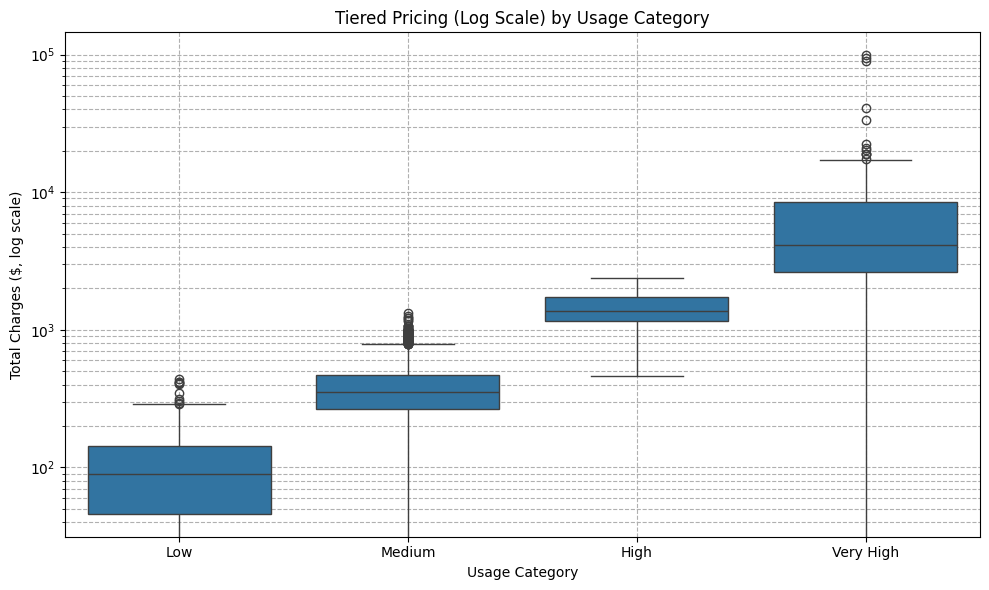

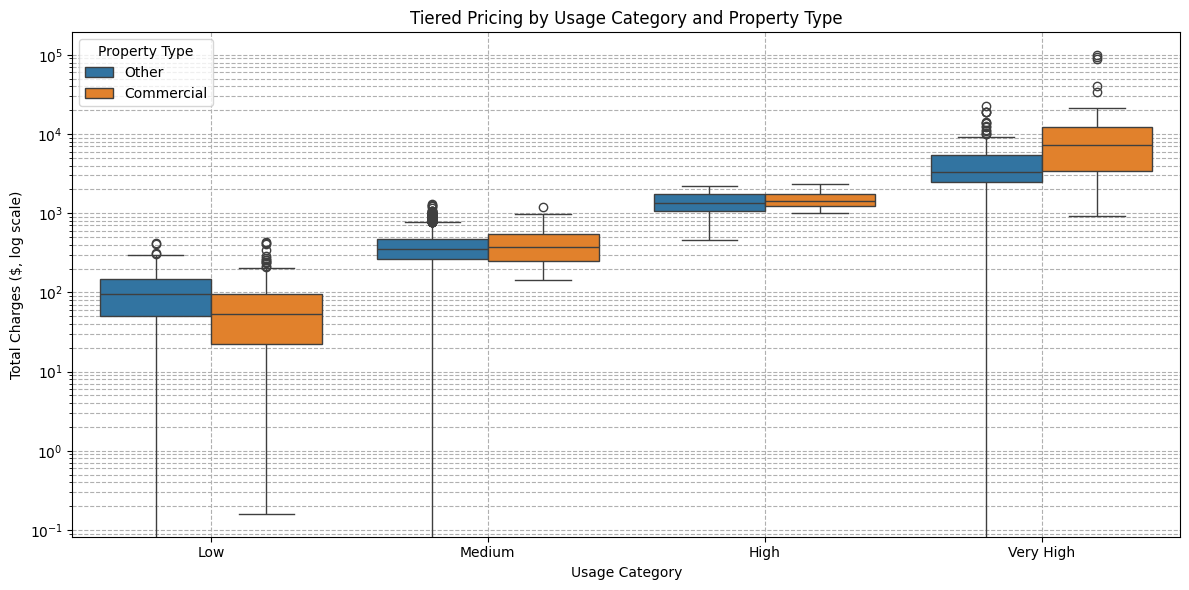

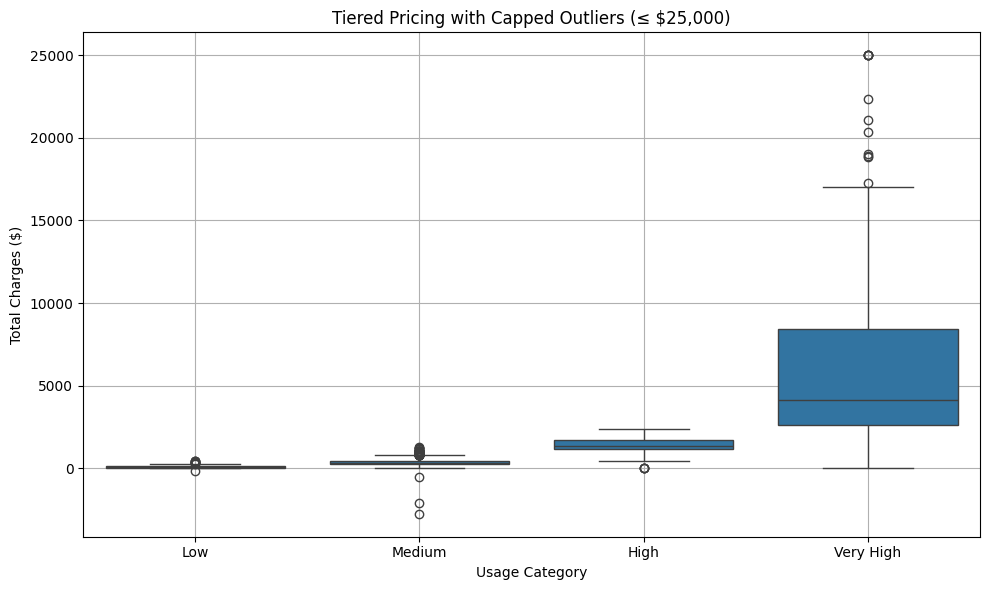

In [9]:
# --- 1. Log-Scale Boxplot ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='usage_category', y='current_total_due')
plt.yscale('log')
plt.title('Tiered Pricing (Log Scale) by Usage Category')
plt.ylabel('Total Charges ($, log scale)')
plt.xlabel('Usage Category')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- 2. Boxplot by Property Type ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='usage_category', y='current_total_due', hue='property_category')
plt.yscale('log')
plt.title('Tiered Pricing by Usage Category and Property Type')
plt.ylabel('Total Charges ($, log scale)')
plt.xlabel('Usage Category')
plt.legend(title='Property Type')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- 3. Boxplot with Capped Outliers ---
df['capped_total_due'] = np.where(df['current_total_due'] > 25000, 25000, df['current_total_due'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='usage_category', y='capped_total_due')
plt.title('Tiered Pricing with Capped Outliers (≤ $25,000)')
plt.ylabel('Total Charges ($)')
plt.xlabel('Usage Category')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Drop rows with missing values in required columns
df = df.dropna(subset=['current_water_charge', 'meter_size'])

# Create squared term for polynomial regression
df['meter_size2'] = df['meter_size'] ** 2

# Run OLS regression model
model = smf.ols(
    'current_water_charge ~ meter_size + meter_size2 + C(property_category) + new_senior_discount',
    data=df
).fit()

# Display summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     current_water_charge   R-squared:                       0.103
Model:                              OLS   Adj. R-squared:                  0.102
Method:                   Least Squares   F-statistic:                     148.9
Date:                  Wed, 07 May 2025   Prob (F-statistic):          9.32e-121
Time:                          22:10:29   Log-Likelihood:                -44981.
No. Observations:                  5188   AIC:                         8.997e+04
Df Residuals:                      5183   BIC:                         9.001e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

<ipython-input-10-d3330b6f0c3c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['meter_size2'] = df['meter_size'] ** 2


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


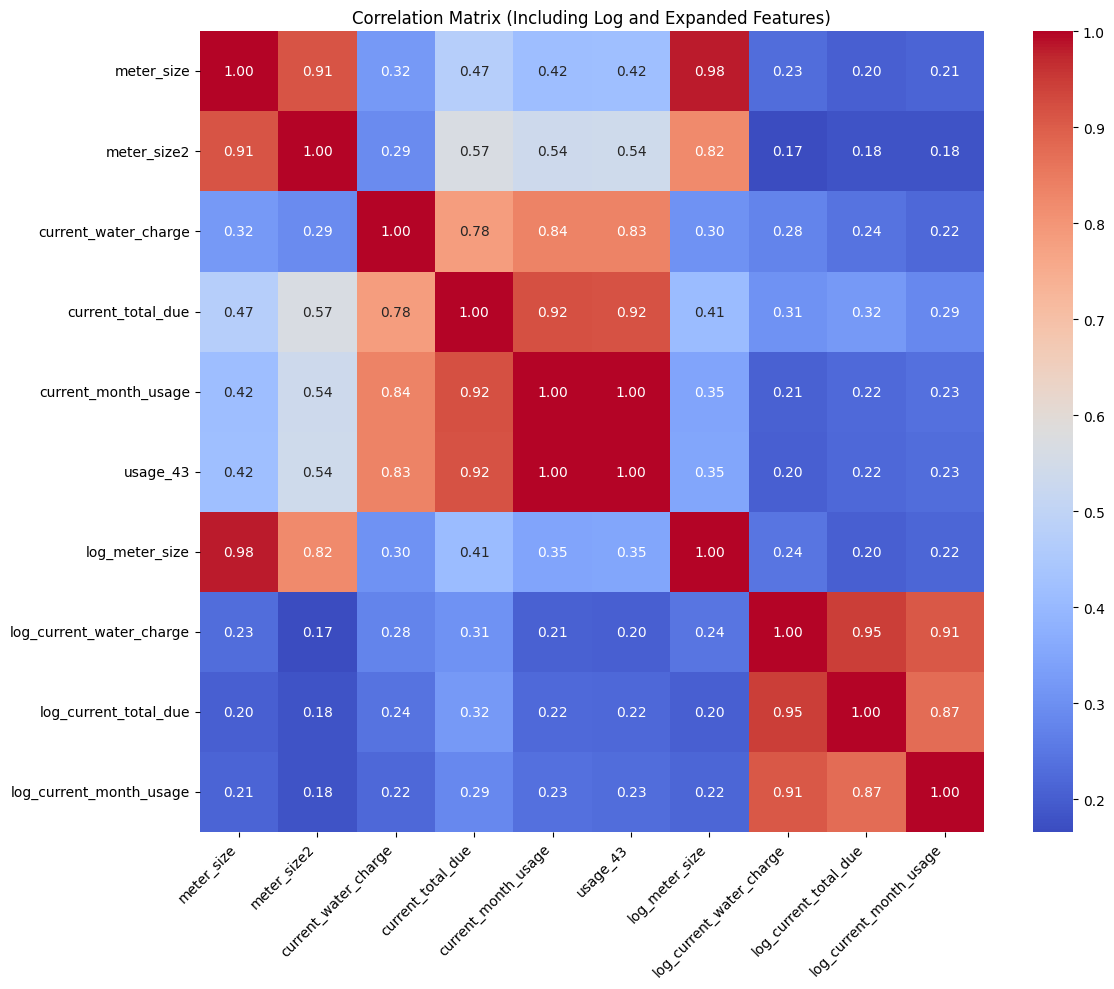

In [11]:
# Create log-transformed variables (add small constant to avoid log(0))
df['log_meter_size'] = np.log1p(df['meter_size'])
df['log_current_total_due'] = np.log1p(df['current_total_due'])
df['log_current_water_charge'] = np.log1p(df['current_water_charge'])
df['log_current_month_usage'] = np.log1p(df['current_month_usage'])

# Create correlation matrix with original + transformed + expanded features
corr_vars = [
    'meter_size', 'meter_size2',
    'current_water_charge', 'current_total_due', 'current_month_usage', 'usage_43',
    'log_meter_size', 'log_current_water_charge', 'log_current_total_due', 'log_current_month_usage'
]

# Drop rows with any NaNs in selected variables
df_corr = df[corr_vars].dropna()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Including Log and Expanded Features)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

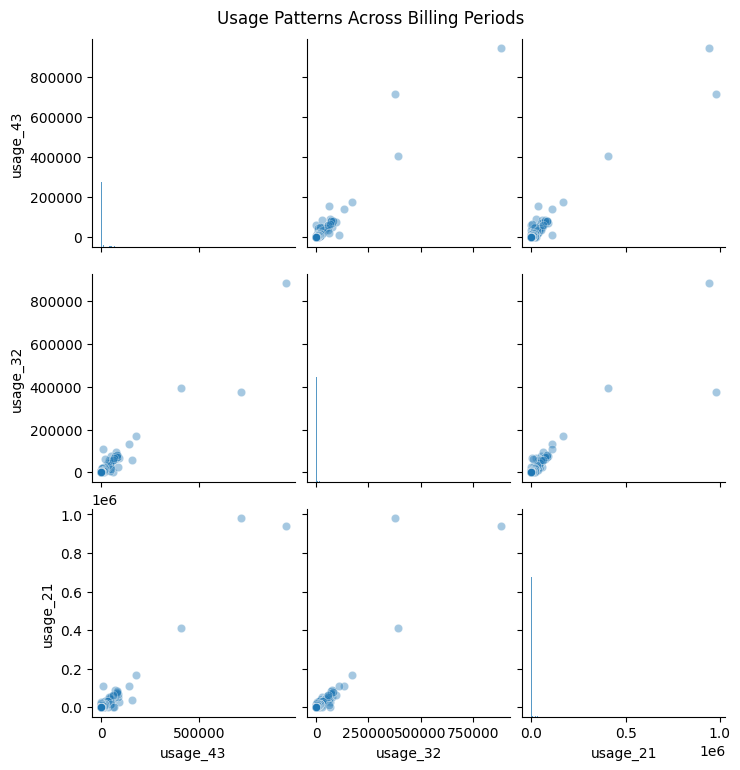

In [13]:
# Scatter plot matrix of historical usage periods
sns.pairplot(df[['usage_43', 'usage_32', 'usage_21']], plot_kws={'alpha': 0.4})
plt.suptitle("Usage Patterns Across Billing Periods", y=1.02)
plt.show()